# Neural Network 

#### Task:
Predict the burned area of forest fires with neural networks.

#### Data description:
- month :	month of the year: 'jan' to 'dec'
- day :	day of the week: 'mon' to 'sun'
- FFMC : 	FFMC index from the FWI system: 18.7 to 96.20
- DMC : 	DMC index from the FWI system: 1.1 to 291.3
- DC : DC index from the FWI system: 7.9 to 860.6
- ISI : ISI index from the FWI system: 0.0 to 56.10
- temp :	temperature in Celsius degrees: 2.2 to 33.30
- RH :	relative humidity in %: 15.0 to 100
- wind :	wind speed in km/h: 0.40 to 9.40
- rain :	outside rain in mm/m2 : 0.0 to 6.4
- size_category :	the burned area of the forest ( Small , Large)

In [26]:
#load the libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf
tf.debugging.set_log_device_placement(False) 
import warnings
warnings.filterwarnings('ignore')

In [27]:
# Generating reproducible results from same code
tf.random.set_seed(14)  #Reference: https://www.youtube.com/watch?v=4ZhnXxfW8WQ&list=LL&index=1&t=1743s

In [28]:
raw_data = pd.read_csv("/kaggle/input/assignment16tarun/forestfires.csv")
raw_data.head() 
#Dummy variables are also created in this process. However we do not require them since we can use label encoding.

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


In [29]:
df = raw_data.copy() #Removing the dummies at this time
df.drop(df.columns[11:30],axis=1,inplace = True)

In [30]:
df.info() #No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


In [31]:
df.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


<Axes: >

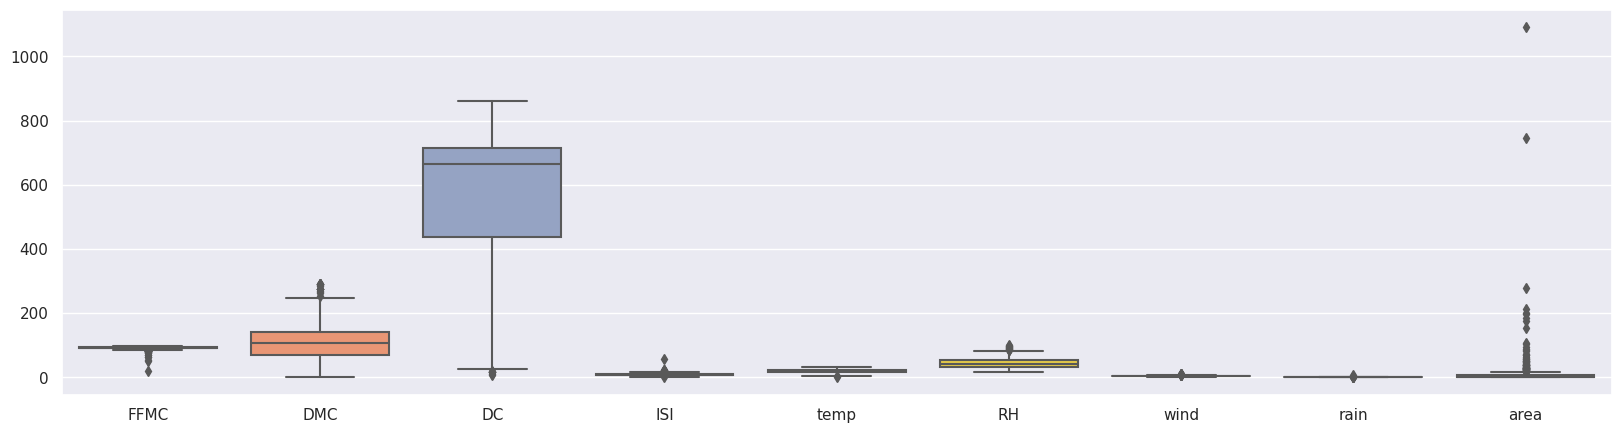

In [32]:
sns.set(rc={'figure.figsize':(20,5)})
sns.boxplot(data=df, orient="v", palette="Set2") 
#There are outliers in the case of area. But we cannot discard it

## Feature Analysis

All features in the dataset can be used in model building. 

In [33]:
df.month.value_counts()

month
aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: count, dtype: int64

In [34]:
df.size_category.value_counts() # The dataset is biased. Lets remove the bias.

size_category
small    378
large    139
Name: count, dtype: int64

In [35]:
#We are going to perform label encoding since it is faster than dummy variables

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df.month= label_encoder.fit_transform(df.month) 
df.day= label_encoder.fit_transform(df.day) 
df.size_category= label_encoder.fit_transform(df.size_category) 
df.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1
1,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,1
2,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,1
3,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1
4,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,1


### Removing Bias in the Dataset

In [36]:
from imblearn.combine import SMOTETomek
from collections import Counter

resamp = df.copy()
#SMOTEK TECHNIQUE

#Define dataset
a = resamp.iloc[:,:-1]
b = resamp.iloc[:,-1]

#Count before
print(Counter(b))

smt = SMOTETomek(sampling_strategy = 'auto')
a, b = smt.fit_resample(a, b)

#Count after
print(Counter(b)) #removed bias in dataset

Counter({1: 378, 0: 139})
Counter({1: 373, 0: 373})


### Train | Split dataset
#### Original Dataset

In [37]:
X = a
Y = b
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3)

### Visualizing the data

Text(0.5, 1.0, 'T-Sine Visualization of forest-fire dataset')

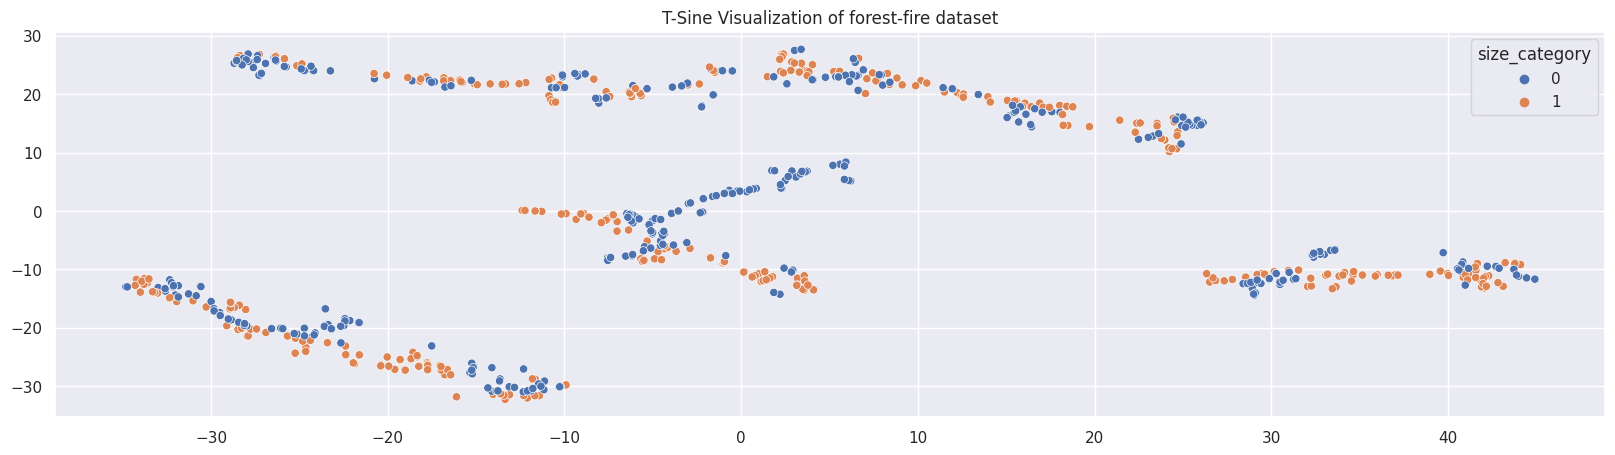

In [39]:
#Visualising the data via dimensionality reduction t-Sine Technique
from sklearn.manifold import TSNE

data_tsne_pca = TSNE(n_components=2).fit_transform(a)
sns.scatterplot(x=data_tsne_pca[:,0],y=data_tsne_pca[:,1],hue=b, palette="deep").set_title('T-Sine Visualization of forest-fire dataset')

## Neural Network Modelling
#### Building the Model

In [40]:
import keras 
from keras.models import Sequential
from keras.layers import Dense

In [41]:
import keras
keras. __version__ #init method is not available in this mdethod

'2.12.0'

In [42]:
# create model
model1 = Sequential()
model1.add(Dense(14, input_dim=11, kernel_initializer='uniform', activation='relu'))
model1.add(Dense(12,kernel_initializer='uniform', activation='relu'))
model1.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

In [43]:
# Compile model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
# Fit the model
hist1 = model1.fit(X_train, y_train, validation_split=0.33, epochs=30, batch_size=10)
#At epoch 25 itself our model reaches accuracy of 98% which maybe overfitting

Epoch 1/30
35/35 [==============================] - 1s 9ms/step - loss: 0.6938 - accuracy: 0.4585 - val_loss: 0.6927 - val_accuracy: 0.5145
Epoch 2/30
35/35 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5072 - val_loss: 0.6905 - val_accuracy: 0.5491
Epoch 3/30
35/35 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5788 - val_loss: 0.6856 - val_accuracy: 0.6185
Epoch 4/30
35/35 [==============================] - 0s 3ms/step - loss: 0.6782 - accuracy: 0.6103 - val_loss: 0.6448 - val_accuracy: 0.6358
Epoch 5/30
35/35 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6418 - val_loss: 0.6052 - val_accuracy: 0.6069
Epoch 6/30
35/35 [==============================] - 0s 3ms/step - loss: 0.5649 - accuracy: 0.7507 - val_loss: 0.4685 - val_accuracy: 0.8092
Epoch 7/30
35/35 [==============================] - 0s 4ms/step - loss: 0.4458 - accuracy: 0.8539 - val_loss: 0.3562 - val_accuracy: 0.9191
Epoch 8/30
35/35 [==

In [45]:
model1.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 14)                168       
                                                                 
 dense_4 (Dense)             (None, 12)                180       
                                                                 
 dense_5 (Dense)             (None, 1)                 13        
                                                                 
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


#### Model Evaluation

In [46]:
test_loss, test_acc = model1.evaluate(X_test, y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.0949 - accuracy: 0.9554


In [47]:
print(hist1.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [48]:
hist1_df = pd.DataFrame(hist1.history)
hist1_df["epoch"]=hist1.epoch
hist1_df.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
25,0.038186,0.985673,0.031659,1.000000,25
26,0.044227,0.988539,0.260537,0.924855,26
27,0.041124,0.985673,0.061405,0.971098,27
28,0.025965,0.994269,0.057160,0.971098,28
29,0.029288,0.994269,0.133063,0.953757,29


#### Visualize Training History

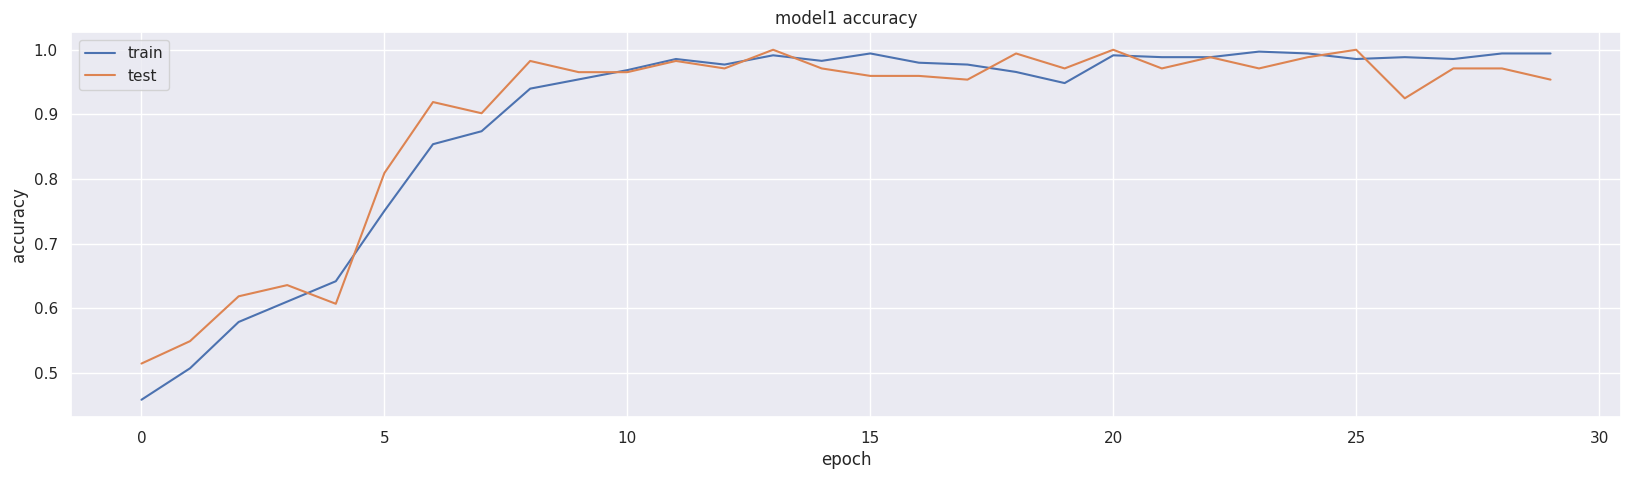

In [49]:
# summarize history for accuracy
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

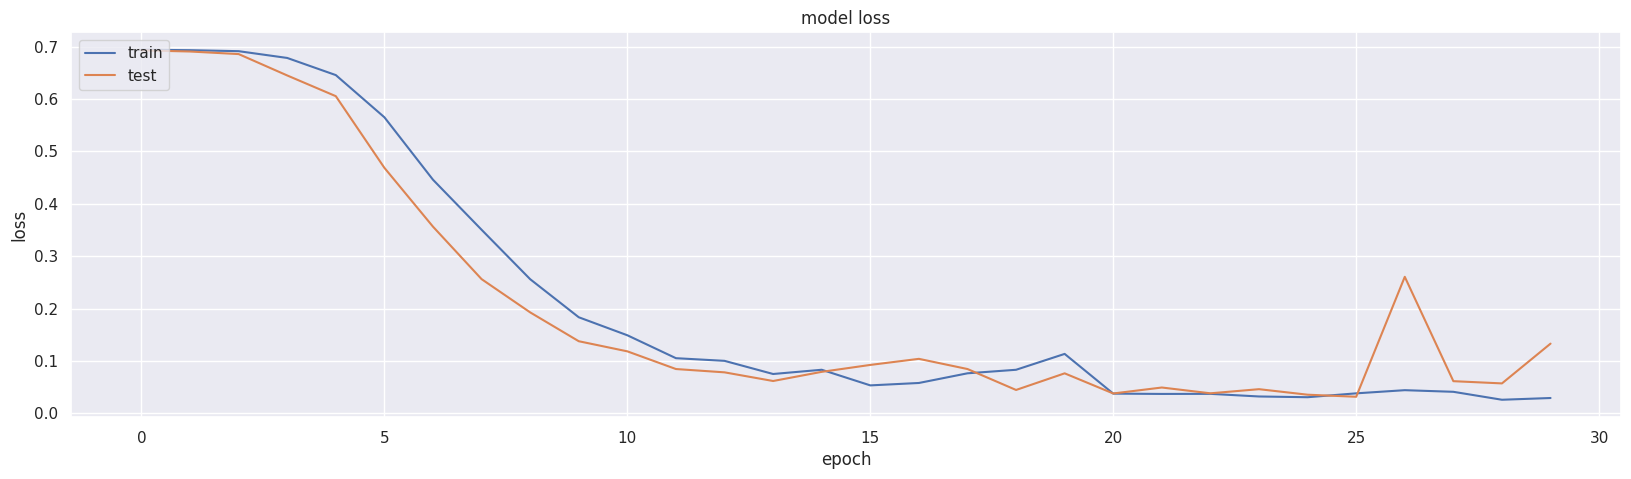

In [50]:
# summarize history for loss
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() #Loss decreases and starts oscillating after 25


## Tuning HyperParameters

#### Standardizing X values

In [51]:
from sklearn.preprocessing import StandardScaler
a = StandardScaler()
a.fit(X)
X_standardized = a.transform(X)

In [52]:
# Importing the necessary packages
from sklearn.model_selection import GridSearchCV, KFold
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

#### Tuning set 1 : Batch Size and Epochs

In [53]:
# create model function
def create_model():
    model = Sequential()
    model.add(Dense(14, input_dim=11, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(12, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    
    adam=Adam(lr=0.01) #learning rate = 0.01
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [54]:
# Create the model
model = KerasClassifier(build_fn = create_model,verbose = 0)
# Define the grid search parameters
batch_size = [10,20,40]
epochs = [10,25,50,100]
# Make a dictionary of the grid search parameters
param_grid = dict(batch_size = batch_size,epochs = epochs)
# Build and fit the GridSearchCV
grid = GridSearchCV(estimator = model,param_grid = param_grid,cv = KFold(),verbose = 10)
grid_result = grid.fit(X_standardized,Y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START batch_size=10, epochs=10...................................
[CV 1/5; 1/12] END ....batch_size=10, epochs=10;, score=1.000 total time=   2.1s
[CV 2/5; 1/12] START batch_size=10, epochs=10...................................
[CV 2/5; 1/12] END ....batch_size=10, epochs=10;, score=0.960 total time=   2.1s
[CV 3/5; 1/12] START batch_size=10, epochs=10...................................
[CV 3/5; 1/12] END ....batch_size=10, epochs=10;, score=0.966 total time=   2.1s
[CV 4/5; 1/12] START batch_size=10, epochs=10...................................
[CV 4/5; 1/12] END ....batch_size=10, epochs=10;, score=0.980 total time=   1.7s
[CV 5/5; 1/12] START batch_size=10, epochs=10...................................
[CV 5/5; 1/12] END ....batch_size=10, epochs=10;, score=0.879 total time=   2.1s
[CV 1/5; 2/12] START batch_size=10, epochs=25...................................
[CV 1/5; 2/12] END ....batch_size=10, epochs=25;

In [55]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print('{},{} with: {}'.format(mean, stdev, param))
#According to this, the best batch size is 20 and epochs is 50

Best : 0.9812080502510071, using {'batch_size': 10, 'epochs': 50}
0.9570469737052918,0.041284721718740224 with: {'batch_size': 10, 'epochs': 10}
0.9771901488304138,0.016773711336830914 with: {'batch_size': 10, 'epochs': 25}
0.9812080502510071,0.014331652879162698 with: {'batch_size': 10, 'epochs': 50}
0.9745055913925171,0.01870482530514829 with: {'batch_size': 10, 'epochs': 100}
0.9355794191360474,0.04216075424614815 with: {'batch_size': 20, 'epochs': 10}
0.9677852392196655,0.032158797425945435 with: {'batch_size': 20, 'epochs': 25}
0.9718210220336914,0.019645687993774787 with: {'batch_size': 20, 'epochs': 50}
0.9731632947921753,0.02364094580187334 with: {'batch_size': 20, 'epochs': 100}
0.9369664311408996,0.043647208775272985 with: {'batch_size': 40, 'epochs': 10}
0.9785234808921814,0.01665726966258986 with: {'batch_size': 40, 'epochs': 25}
0.9758389353752136,0.019727438824461326 with: {'batch_size': 40, 'epochs': 50}
0.9704966425895691,0.012468167184050085 with: {'batch_size': 40, 'e

#### Tuning set 2 : Learning Rate and Dropout Rate

In [56]:
from keras.layers import Dropout

# Defining the model

def create_model2(learning_rate,dropout_rate):
    model = Sequential()
    model.add(Dense(14,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(12,input_dim = 14,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,kernel_initializer='uniform',activation = 'sigmoid'))
    
    adam = Adam(lr = learning_rate)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model

model2 = KerasClassifier(build_fn = create_model2,verbose = 0,batch_size = 20,epochs = 50)

# Define the grid search parameters

learning_rate = [0.001,0.01,0.1]
dropout_rate = [0.0,0.1,0.2]

# Make a dictionary of the grid search parameters

param_grids2 = dict(learning_rate = learning_rate,dropout_rate = dropout_rate)

# Build and fit the GridSearchCV

grid2 = GridSearchCV(estimator = model2,param_grid = param_grids2,cv = KFold(),verbose = 10)
grid_result2 = grid2.fit(X_standardized,Y)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 1/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.993 total time=   3.6s
[CV 2/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 2/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.987 total time=   6.0s
[CV 3/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 3/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.960 total time=   3.8s
[CV 4/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 4/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.980 total time=   4.6s
[CV 5/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 5/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.987 total time=   3.8s
[CV 1/5; 2/9] START dropout_rate=0.0, learning_rate=0.01........................
[CV 1/5; 

In [57]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result2.best_score_,grid_result2.best_params_))
means2 = grid_result2.cv_results_['mean_test_score']
stds2 = grid_result2.cv_results_['std_test_score']
params2 = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means2, stds2, params2):
  print('{},{} with: {}'.format(mean, stdev, param))
#Best score for Dropout rate = 0.2 and learning rate is 0.001

Best : 0.9865771651268005, using {'dropout_rate': 0.2, 'learning_rate': 0.001}
0.9812169909477234,0.011556122417073177 with: {'dropout_rate': 0.0, 'learning_rate': 0.001}
0.9745055913925171,0.020541149336319505 with: {'dropout_rate': 0.0, 'learning_rate': 0.01}
0.958433997631073,0.031605078428850665 with: {'dropout_rate': 0.0, 'learning_rate': 0.1}
0.9852348804473877,0.013688649336326294 with: {'dropout_rate': 0.1, 'learning_rate': 0.001}
0.9704787373542786,0.022709054718455704 with: {'dropout_rate': 0.1, 'learning_rate': 0.01}
0.9302908301353454,0.03412365155774661 with: {'dropout_rate': 0.1, 'learning_rate': 0.1}
0.9865771651268005,0.011230337982590278 with: {'dropout_rate': 0.2, 'learning_rate': 0.001}
0.9745055913925171,0.011561324773309652 with: {'dropout_rate': 0.2, 'learning_rate': 0.01}
0.8456554889678956,0.15539658933904418 with: {'dropout_rate': 0.2, 'learning_rate': 0.1}


#### Tuning set 3 : Activation Function and Kernel Initializer

In [58]:
# Defining the model

def create_model3(activation_function,init):
    model = Sequential()
    model.add(Dense(14,input_dim = 11,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.2))
    model.add(Dense(12,input_dim = 14,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model

model3 = KerasClassifier(build_fn = create_model3,verbose = 0,batch_size = 20,epochs = 50)

# Define the grid search parameters
activation_function = ['softmax','relu','tanh','linear']
init = ['uniform','normal','zero']

# Make a dictionary of the grid search parameters
param_grids3 = dict(activation_function = activation_function,init = init)

# Build and fit the GridSearchCV

grid3 = GridSearchCV(estimator = model3,param_grid = param_grids3,cv = KFold(),verbose = 10)
grid_result3 = grid3.fit(X_standardized,Y)



Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 1/5; 1/12] END activation_function=softmax, init=uniform;, score=0.053 total time=   3.9s
[CV 2/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 2/5; 1/12] END activation_function=softmax, init=uniform;, score=0.752 total time=   6.1s
[CV 3/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 3/5; 1/12] END activation_function=softmax, init=uniform;, score=0.436 total time=   3.9s
[CV 4/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 4/5; 1/12] END activation_function=softmax, init=uniform;, score=0.651 total time=   3.8s
[CV 5/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 5/5; 1/12] END activation_function=softmax, init=uniform;, score=0.221 total time=   4.0s
[CV 1/5; 2/12] START activation_function=softmax, init=normal...

In [59]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result3.best_score_,grid_result3.best_params_))
means3 = grid_result3.cv_results_['mean_test_score']
stds3 = grid_result3.cv_results_['std_test_score']
params3 = grid_result3.cv_results_['params']
for mean, stdev, param in zip(means3, stds3, params3):
  print('{},{} with: {}'.format(mean, stdev, param))
#best activation function in our case would be Relu and Kernel Initializer is Uniform

Best : 0.990604019165039, using {'activation_function': 'tanh', 'init': 'normal'}
0.4227472022175789,0.2597908305276592 with: {'activation_function': 'softmax', 'init': 'uniform'}
0.4347561448812485,0.26064506618725164 with: {'activation_function': 'softmax', 'init': 'normal'}
0.4093959778547287,0.29093786476991546 with: {'activation_function': 'softmax', 'init': 'zero'}
0.9798657655715942,0.018008594303270925 with: {'activation_function': 'relu', 'init': 'uniform'}
0.9865771770477295,0.011230330858469447 with: {'activation_function': 'relu', 'init': 'normal'}
0.20536913275718688,0.18621470654954517 with: {'activation_function': 'relu', 'init': 'zero'}
0.9879194498062134,0.00890368951829549 with: {'activation_function': 'tanh', 'init': 'uniform'}
0.990604019165039,0.012447812890821868 with: {'activation_function': 'tanh', 'init': 'normal'}
0.20536913275718688,0.18621470654954517 with: {'activation_function': 'tanh', 'init': 'zero'}
0.990604019165039,0.009103794777687855 with: {'activat

#### Tuning Set 4: Number of neurons in activation layer

In [60]:
# Defining the model

def create_model4(neuron1,neuron2):
    model = Sequential()
    model.add(Dense(neuron1,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model

model4 = KerasClassifier(build_fn = create_model4,verbose = 0,batch_size = 20,epochs = 50)

# Define the grid search parameters

neuron1 = [4,8,14]
neuron2 = [4,8,12]

# Make a dictionary of the grid search parameters

param_grids4 = dict(neuron1 = neuron1,neuron2 = neuron2)

# Build and fit the GridSearchCV

grid4 = GridSearchCV(estimator = model4,param_grid = param_grids4,cv = KFold(),verbose = 10)
grid_result4 = grid4.fit(X_standardized,Y)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 1/5; 1/9] END .........neuron1=4, neuron2=4;, score=1.000 total time=   4.1s
[CV 2/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 2/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.980 total time=   3.5s
[CV 3/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 3/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.953 total time=   3.4s
[CV 4/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 4/5; 1/9] END .........neuron1=4, neuron2=4;, score=1.000 total time=   3.6s
[CV 5/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 5/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.980 total time=   3.2s
[CV 1/5; 2/9] START neuron1=4, neuron2=8........................................
[CV 1/5; 2/9] END .........neuron1=4, neuron2=8;,

In [61]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result4.best_score_,grid_result4.best_params_))
means4 = grid_result4.cv_results_['mean_test_score']
stds4 = grid_result4.cv_results_['std_test_score']
params4 = grid_result4.cv_results_['params']
for mean, stdev, param in zip(means4, stds4, params4):
  print('{},{} with: {}'.format(mean, stdev, param))

#Best results are Neuron 1 = 4 and Neuron 2 = 4

Best : 0.9865771770477295, using {'neuron1': 14, 'neuron2': 12}
0.9825503468513489,0.017294083917236813 with: {'neuron1': 4, 'neuron2': 4}
0.9677941799163818,0.04253685692052716 with: {'neuron1': 4, 'neuron2': 8}
0.9691364526748657,0.017819527224372918 with: {'neuron1': 4, 'neuron2': 12}
0.9771812081336975,0.02637164169528337 with: {'neuron1': 8, 'neuron2': 4}
0.9838926076889039,0.013819642288034888 with: {'neuron1': 8, 'neuron2': 8}
0.9838926076889039,0.016218842108181017 with: {'neuron1': 8, 'neuron2': 12}
0.9865771651268005,0.011230337982590278 with: {'neuron1': 14, 'neuron2': 4}
0.9825503349304199,0.012447809034425033 with: {'neuron1': 14, 'neuron2': 8}
0.9865771770477295,0.015304373911175662 with: {'neuron1': 14, 'neuron2': 12}


## Building Final Model

In [63]:
# Defining the model

def create_model_fnl():
    model = Sequential()
    model.add(Dense(4,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4,input_dim = 4,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001) #sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [64]:
# Create the model
model_fnl = KerasClassifier(build_fn = create_model_fnl,verbose = 0,batch_size = 20,epochs = 50)

In [65]:
#Making training and Testing Data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_standardized,Y, test_size = 0.3)


In [66]:
# Fitting the model
hist2 = model_fnl.fit(X_train_1,y_train_1)

In [68]:
import seaborn as sns
def confusion_matri(cf_matrix):
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    plt.show()

In [71]:
from sklearn.metrics import confusion_matrix,classification_report
def report_model(model):
    model_preds = model.predict(X_test_1)
    print(confusion_matrix(y_test_1,model_preds))
    cf_matrix = confusion_matrix(y_test,model_preds)
    confusion_matri(cf_matrix)

7/7 [==============================] - 0s 2ms/step
[[ 85  13]
 [  0 126]]


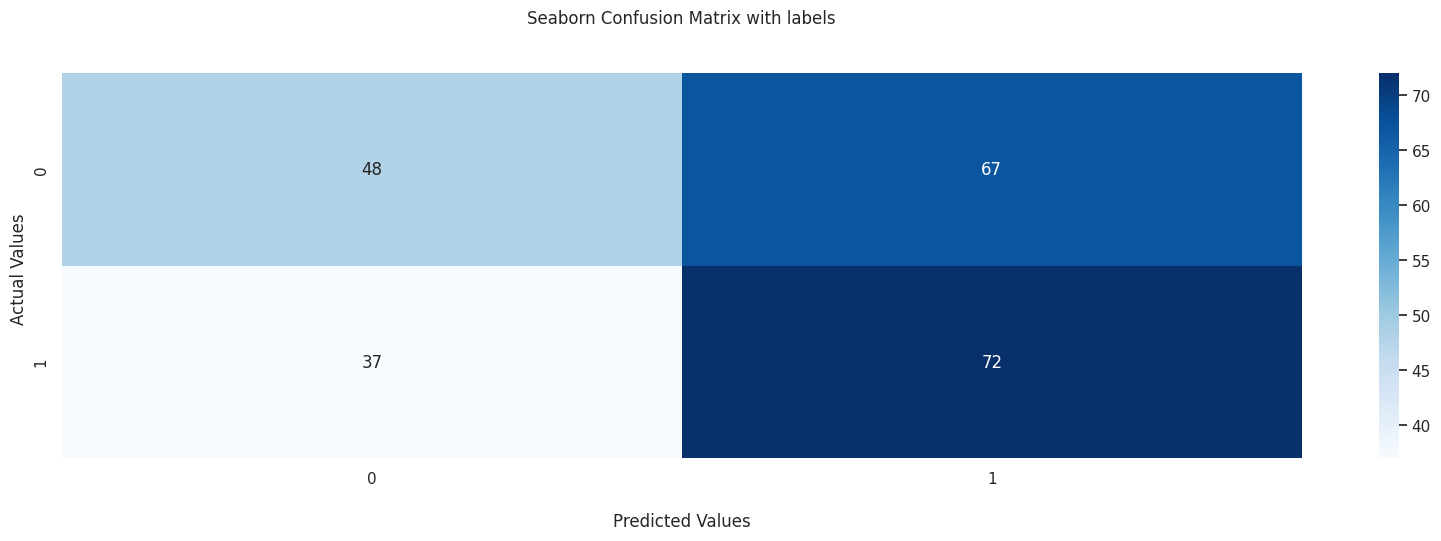

In [72]:
report_model(model_fnl)

## Conclusion
- EDA was perfomed on initial dataset and all errors were removed.
- Inbuilt databias of the dataset was rectified.
- A general Neural Network was built first using random Parameters.
- Training history plotting was done for the above model.
- Tuning of HyperParameters was perfomed
- An optimised Final Model was built with all the optimum hyperparameters.
- Final model report was obtained.